In [91]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import Imputer

In [92]:
%pylab inline
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")

Populating the interactive namespace from numpy and matplotlib


C:\Users\akabo\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [94]:
inputfilename = "https://raw.githubusercontent.com/abehmiel/data-science-take-home-challenges/master/01-converson-rate/conversion_data.csv"
dataframe = pd.read_csv(inputfilename)
dataframe.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


## Have a look of the Age!

(316200, 6)

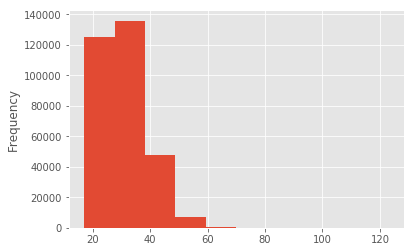

In [95]:
dataframe.head()
dataframe.age.plot(kind= "hist")
dataframe.shape

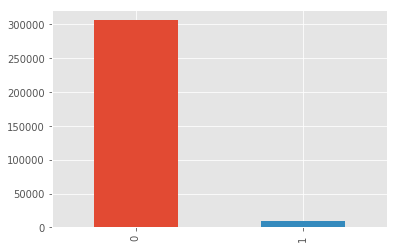

In [96]:
a = dataframe.converted.value_counts()
a.plot(kind= "bar")

# China, a country with lots of users but low conversion, in contrast to Germany

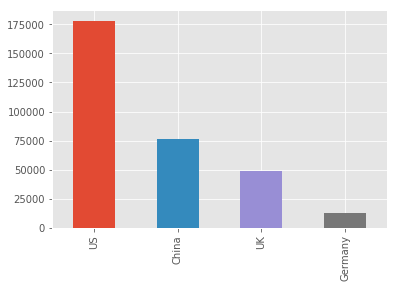

In [99]:
country_dist = dataframe.country.value_counts()
country_dist.plot(kind="bar")

In [137]:
print(dataframe.groupby("country").converted.mean())
b=dataframe[(dataframe.age <100) & (dataframe.age >60)]
b.converted.sum()

country
China      0.001332
Germany    0.062500
UK         0.052632
US         0.037801
Name: converted, dtype: float64


1

# Clean the Age data

In [66]:
dataframe.age.value_counts()
b = dataframe[dataframe.age>100]
dataframe = dataframe[~dataframe.age.isin (b)]
dataframe.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


# Dummy the Categorial Variable without normalization 

In [101]:
dataframe.country = dataframe.country.astype("category")
f2dummy= pd.get_dummies(dataframe['country'], prefix='country')
dataframe1 = pd.concat([dataframe, f2dummy],axis=1)
dataframe1=dataframe1.drop("country",axis=1)
dateframe1 = dataframe1.drop("country_Germany",axis=1)
dataframe1.source = dataframe1.source.astype("category")
dummy= pd.get_dummies(dataframe1['source'], prefix='source')
dataframe2 = pd.concat([dataframe1, dummy],axis=1)
dataframe3 =dataframe2.drop("source",axis=1)

In [102]:
dataframe3.head()

,age,new_user,total_pages_visited,converted,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0,0,1,0,1,0,0
1,23,1,5,0,0,0,0,1,0,0,1
2,28,1,4,0,0,0,0,1,0,0,1
3,39,1,5,0,1,0,0,0,0,0,1
4,30,1,6,0,0,0,0,1,0,0,1


# Modeling without upsampling of the target variable!

In [83]:
from sklearn.tree import DecisionTreeClassifier
y =dataframe3.converted
X= dataframe3.drop(["converted"],axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size = 0.20,random_state = 42,stratify= y)

from sklearn.linear_model import LogisticRegression 
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV 
gslr = GridSearchCV(estimator=LogisticRegression(random_state=0),
                  param_grid=[{'C': [ 0.001, 0.01, 0.1 ,1 ,10 ,100],
                             'penalty':['l1','l2']}],
                  scoring='accuracy',
                  cv=10)
gslr_fit = gslr.fit(X_train, y_train)
y_pred = gslr_fit.predict(X_test)
y_pred1 = gslr_fit.predict_proba(X_test)
y_pro = y_pred1[:,1]

## best parameter
print(gslr.best_params_)
from sklearn.metrics import precision_score, recall_score
print("precision_score: ", precision_score(y_test,y_pred))
print("recall_score: ", recall_score(y_test,y_pred))

from sklearn.metrics import f1_score
print("f1_score: ",f1_score(y_test,y_pred))
accuracy = sum(y_pred == y_test)/len(y_test)
error = 1 - accuracy
print("The predictive accuracy is: ", round(accuracy, 2))
print("The classification error is: ", round(error, 2))

# Confusion matrix
from sklearn.metrics import confusion_matrix

cnf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = ['Predict 0', 'Predict 1'], index = ['Actual 0', 'Actual 1'])
print("The Confusion matrix: \n", cnf_matrix)



{'C': 0.1, 'penalty': 'l1'}
precision_score:  0.853836784409257
recall_score:  0.6872549019607843
f1_score:  0.761542639869636
The predictive accuracy is:  0.99
The classification error is:  0.01
The Confusion matrix: 
           Predict 0  Predict 1
Actual 0      60960        240
Actual 1        638       1402


Confusion matrix, without normalization
[[60960   240]
 [  638  1402]]
Normalized confusion matrix
[[1.   0.  ]
 [0.31 0.69]]


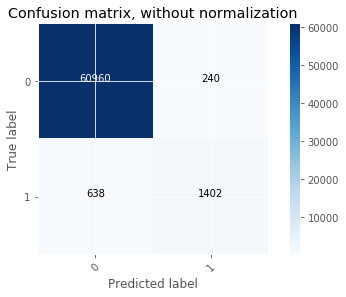

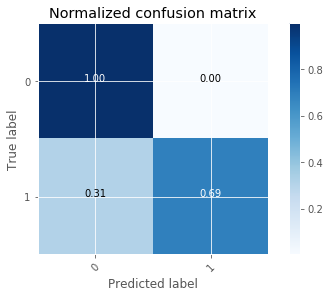

In [85]:
import itertools
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

    
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["0","1"],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["0","1"], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [112]:
train=dataframe3.sample(frac=0.8,random_state=42)
test=dataframe3.drop(train.index)
train_majority = train[train.converted==0]
train_minority = train[train.converted==1]
print(train_majority.shape)
print(train_minority.shape)
from sklearn.utils import resample

train_minority = resample(train_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=81240,    # 5x upsampling
                                 random_state=42)  # reproducible results

train = pd.concat([train_majority, train_minority])
 
# Display new class counts
train.converted.value_counts()

(244836, 11)
(8124, 11)


0    244836
1     81240
Name: converted, dtype: int64

# Modeling with the upsampling of the target variables

In [113]:
ytrain= train["converted"]
Xtrain = train.drop("converted",axis=1)
ytest= test["converted"]
Xtest= test.drop("converted",axis=1)

In [114]:
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV 
gslr = GridSearchCV(estimator=LogisticRegression(random_state=0),
                  param_grid=[{'C': [ 0.001, 0.01, 0.1 ,1 ,10 ,100],
                             'penalty':['l1','l2']}],
                  scoring='accuracy',
                  cv=10)
gslr_fit = gslr.fit(Xtrain, ytrain)
ypred = gslr_fit.predict(Xtest)
ypred1 = gslr_fit.predict_proba(Xtest)
ypro = y_pred1[:,1]

## best parameter
print(gslr.best_params_)
from sklearn.metrics import precision_score, recall_score
print("precision_score: ", precision_score(ytest,ypred))
print("recall_score: ", recall_score(ytest,ypred))

from sklearn.metrics import f1_score
print("f1_score: ",f1_score(ytest,ypred))
accuracy = sum(y_pred == ytest)/len(ytest)
error = 1 - accuracy
print("The predictive accuracy is: ", round(accuracy, 2))
print("The classification error is: ", round(error, 2))

# Confusion matrix
from sklearn.metrics import confusion_matrix

cnf_matrix = pd.DataFrame(confusion_matrix(ytest, ypred), columns = ['Predict 0', 'Predict 1'], index = ['Actual 0', 'Actual 1'])
print("The Confusion matrix: \n", cnf_matrix)


{'C': 1, 'penalty': 'l1'}
precision_score:  0.5210060017147756
recall_score:  0.878131021194605
f1_score:  0.6539910313901345
The predictive accuracy is:  0.94
The classification error is:  0.06
The Confusion matrix: 
           Predict 0  Predict 1
Actual 0      59488       1676
Actual 1        253       1823


The recall seems to be better!

In [140]:
from sklearn.linear_model import LogisticRegressionCV
lrcv = LogisticRegressionCV(Cs = np.logspace(-3,3,7),
                            dual=False,
                            scoring='roc_auc',
                            max_iter=1000,
                            n_jobs=-1,
                            verbose=1)
lrcv.fit(Xtrain,ytrain)



[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.2s finished


LogisticRegressionCV(Cs=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
           class_weight=None, cv=None, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=1000, multi_class='ovr',
           n_jobs=-1, penalty='l2', random_state=None, refit=True,
           scoring='roc_auc', solver='lbfgs', tol=0.0001, verbose=1)

In [134]:
feat_importances = pd.DataFrame({"name":Xtrain.columns,"coef":lrcv.coef_[0]})
feat_importances.sort_values(by="coef",inplace=True,ascending=False)
feat_importances

,name,coef
4,country_Germany,1.175243
5,country_UK,0.917204
2,total_pages_visited,0.751265
6,country_US,0.623208
9,source_Seo,0.019640
7,source_Ads,0.014327
0,age,-0.070845
8,source_Direct,-0.138828
1,new_user,-1.649268
3,country_China,-2.820516


# Our insights:
1.conversion among China users are very bad. from inspection, we know that there are lot of users coming from China, but their conversion rate is very low. Consider China's economic and population, there is a huge opportunity if we target Chinese users and improve their conversion rate. we should consider whether our website has good Chinese translation and satisfy Chinese users' culture requirement.



2.conversion from Germany is good. but inspection, we know that there isn't a lot of users from German. so it's a huge opportuntity for us to target German users. for example, put more advertisement in German.


3.Age is a negative factor



4.total_pages_visited is positive


5.new user is negative

# Try of Imputer!

In [142]:
# Create an empty dataset
df = pd.DataFrame()

# Create two variables called x0 and x1. Make the first value of x1 a missing value
df['x0'] = [0.3051,0.4949,0.6974,0.3769,0.2231,0.341,0.4436,0.5897,0.6308,0.5]
df['x1'] = [np.nan,0.2654,0.2615,0.5846,0.4615,0.8308,0.4962,0.3269,0.5346,0.6731]

# View the dataset
df

,x0,x1
0,0.3051,NaN
1,0.4949,0.2654
2,0.6974,0.2615
3,0.3769,0.5846
4,0.2231,0.4615
5,0.3410,0.8308
6,0.4436,0.4962
7,0.5897,0.3269
8,0.6308,0.5346
9,0.5000,0.6731


In [143]:
# Create an imputer object that looks for 'Nan' values, then replaces them with the mean value of the feature by columns (axis=0)
mean_imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)

# Train the imputor on the df dataset
mean_imputer = mean_imputer.fit(df.values)
# Apply the imputer to the df dataset
imputed_df = mean_imputer.transform(df.values)

In [144]:
imputed_df

array([[0.31, 0.49],
       [0.49, 0.27],
       [0.7 , 0.26],
       [0.38, 0.58],
       [0.22, 0.46],
       [0.34, 0.83],
       [0.44, 0.5 ],
       [0.59, 0.33],
       [0.63, 0.53],
       [0.5 , 0.67]])

In [145]:
df.values

array([[0.31,  nan],
       [0.49, 0.27],
       [0.7 , 0.26],
       [0.38, 0.58],
       [0.22, 0.46],
       [0.34, 0.83],
       [0.44, 0.5 ],
       [0.59, 0.33],
       [0.63, 0.53],
       [0.5 , 0.67]])